# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

First create fake data.

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(8000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(1600)

sampler._sampler.set_f_s_threshold(4)

Run the sampler!

In [3]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 8000
Total number of posterior samples: 1600
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     

2140  4151    0:05.8 -144.6340292  0.570514529     6             
2160  4191    0:05.8 -142.9610051  0.569770509     6             
2180  4217    0:05.9 -141.5431136  0.571129159     6             
2200  4253    0:06.1 -140.1376662  0.570983649     6             
2220  4283    0:06.1 -138.7357438  0.571722895     6             
2240  4312    0:06.2 -137.226999   0.572597137     6             
2260  4348    0:06.2 -135.4092983  0.572441743     6             
2280  4389    0:06.2 -133.9182468  0.571571823     6             
2300  4420    0:06.4 -132.2646028  0.572139303     5             
2320  4451    0:06.4 -130.8692556  0.572698099     5             
2340  4491    0:06.4 -129.2487388  0.571987289     5             
2360  4524    0:06.4 -127.8789804  0.572259942     5             
2380  4565    0:06.5 -126.6361765  0.571428571     5             
2400  4608    0:06.6 -125.3832423  0.570342205     6             
2420  4643    0:06.6 -124.0546241  0.570351167     6             
2440  4677

4640  8020    0:12.6 -13.71222083  0.608923885     1             
4660  8044    0:12.6 -13.32901627  0.609628467     1             
4680  8075    0:12.6 -12.94091835  0.609771987     1             
4700  8101    0:12.6 -12.55595816  0.610310349     1             
4720  8133    0:12.6 -12.18235605  0.610371137     1             
4740  8164    0:12.6 -11.82596638  0.610510046     1             
4760  8203    0:12.7 -11.49781435  0.610021786     1             
4780  8232    0:12.7 -11.18090102  0.61031665      1             
4800  8264    0:12.7 -10.87298194  0.610376399     1             
4820  8287    0:12.7 -10.57739762  0.611132243     1             
4840  8313    0:12.8 -10.28223545  0.611651712372  1             
4860  8340    0:12.8 -9.993279815  0.61209068      1             
4880  8368    0:12.8 -9.722011086  0.612449799     1             
4900  8397    0:12.8 -9.4509225    0.612729774     1             
4920  8427    0:12.8 -9.189302861  0.612931357     1             
4940  8452

## Plot posterior samples versus true parameter values (dashed lines)

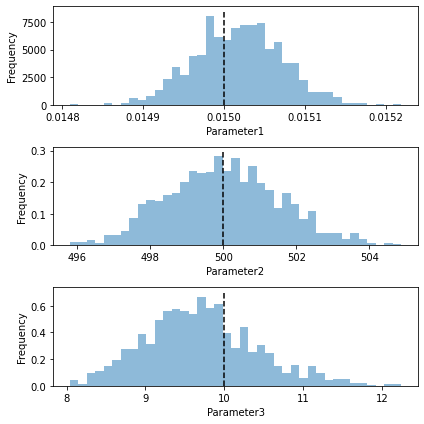

In [4]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=real_parameters)

plt.show()

## Plot posterior predictive simulations versus the observed data

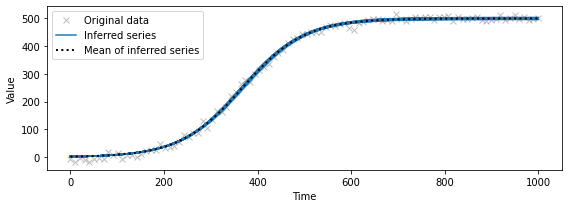

In [5]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [6]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -381.67707063497056 ± 0.08263040269702093


## Effective sample size

In [7]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

effective sample size = 1647.260225300798


# Egg box problem

In [8]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

In [9]:
log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

In [10]:
sampler = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(1000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(500)

sampler._sampler.set_f_s_threshold(1.3)

In [11]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 1000
Total number of posterior samples: 500
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     0

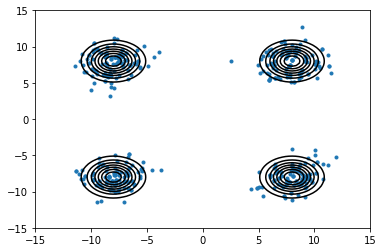

In [12]:
sigma = 2
r = 4
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)

# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(-15 + 30 * samples[:, 0], -15 + 30 * samples[:, 1], marker='.')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

In [13]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

effective sample size = 645.1158877755244


In [14]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.473552541338521 ± 0.06853577670167273
